# *Pre-requisite for this demo*

- *tutorial s1 region simulation*
- *demo exploring longer time series*

# Analyze power spectra

The TVB scripting interface has an interactive tool for visualizing the power spectra of a time series generated in a simulation. This demonstration shows an example of its use, using an example dataset for region-based time series.

As a simple set of example data, we are using a generic oscillatory model, with an intrinsic frequency sets at 10 Hz, and coupled through the default connectivity.

The first thing we need to do, is to import the necessary TVB modules and some additional Python packages to perform the simulation and analyze our results.

In [1]:
%matplotlib widget

# Import tvb library.
from tvb.simulator.lab import *
from tvb.datatypes.time_series import TimeSeriesRegion 
import tvb.simulator.plot.power_spectra_interactive as ps_int

# Import a bunch of stuff to ease command line usage.
import matplotlib.pyplot as plt
import numpy as np
import time as tm

## Example data

In [2]:
# Initialise the Connectivity.
con = connectivity.Connectivity.from_file('connectivity_76.zip') 
nregions = len(con.region_labels)
con.weights = con.weights - con.weights * np.eye((nregions)) #remove self-connection
con.weights = con.weights / np.max(con.weights)              #normalised by maximum weight  
con.speed = np.array([np.inf])                               #no time delays => velocity ->∞
con.configure()

# Initialise the Model.
mod = models.Generic2dOscillator(a=np.array([1.7402]), #a fixed at criticality
                                 d=np.array([0.02]))   #d fixed at default value for a natural frequency 
                                                       #of the model around 10Hz
    
# Initialise the Simulator.
sim = simulator.Simulator(model=mod,
                          connectivity=con,
                          conduction_speed=np.float64(con.speed),
                          coupling=coupling.Difference(a=np.array([0.0075])),
                          integrator=integrators.HeunStochastic(dt=0.1, noise=noise.Additive(nsig=np.array([0.002, 0]))),
                          monitors=(monitors.TemporalAverage(period=1),), #period in ms
                          simulation_length=10e3)
sim.configure()

WARNING  File 'hemispheres' not found in ZIP.


,value
Type,Simulator
conduction_speed,inf
connectivity,Connectivity gid: 965316c0-0f1a-4a74-ad5d-bbace8383273
coupling,Difference gid: 23c05ff9-7fe6-4ffc-b3ef-3ceb1da55aa8
gid,UUID('f624be2a-3c81-4ca3-af97-895e6d2cc5ab')
initial_conditions,None
integrator,HeunStochastic gid: affd3720-1727-4b4b-b940-bfeafe656dc2
model,Generic2dOscillator gid: 59bfb747-c52f-4c90-a6bc-022958687894
monitors,"(,)"
simulation_length,10000.0


In [3]:
# Perform the simulation.
print("Starting simulation...")
tic = tm.time()

(time, tavg), = sim.run() 

# Finished simulation. 
print("Finished simulation.")
print("execute for " + str(tm.time()-tic))

Starting simulation...
Finished simulation.
execute for 26.55780792236328


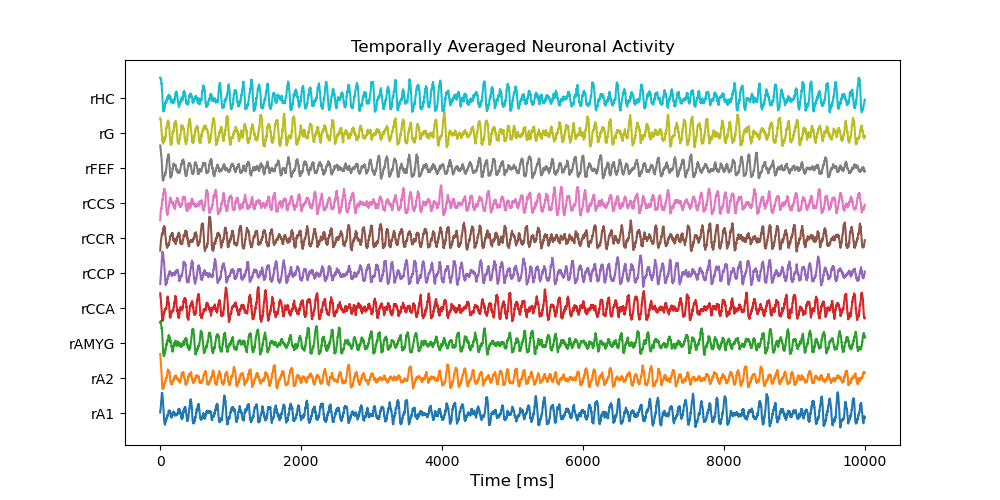

In [4]:
# Normalize time series.
tavg /= (np.max(tavg,0) - np.min(tavg,0 ))
tavg -= np.mean(tavg, 0)

# Plot the temporally averaged time series of the 10th first brain regions.
fig1=plt.figure(figsize=(10,5))
plt.plot(time[:], tavg[:, 0, :10, 0] + np.r_[:10])
plt.title('Temporally Averaged Neuronal Activity', fontsize=12)
plt.xlabel('Time [ms]', fontsize=12)
plt.yticks(range(10), con.region_labels[:10], fontsize=10)

plt.show()

## Compute power spectrum

### Create a time series-based region datatype

The results of the simulation are stored as a simple **4D-array**.
We need to turn it into one of TVB's time series datatypes, which is what the interactive plotting tool operate on, in this case we are using **TimeSeriesRegion** (i.e., region-based simulation).

In [5]:
# Discarded first seconds to avoid initial transient dynamics.
tavg = tavg[1000:10000]

# Build a TimeSeries Dataype.
tsr = TimeSeriesRegion(connectivity=con,
                       data=tavg,                            #in TVB 4D format
                       sample_period=sim.monitors[0].period) #in ms
tsr.configure()
tsr

,value
Dimensions,"('Time', 'State Variable', 'Region', 'Mode')"
Length,9000.0
Region Mapping,None
Region Mapping Volume,None
Sample period,1.0
Source Connectivity,Connectivity gid: 965316c0-0f1a-4a74-ad5d-bbace8383273
Start time,0
Time units,ms
Time-series name,TimeSeriesRegion gid: c55637da-77e7-4c14-a5c8-860aef405373
Time-series type,TimeSeriesRegion


### Create and launch the Power Spectra Interactive graphical interface

Power Spectra Interactive viewer is a tool for analizing and visualizing the power spectrum of **all nodes** in a simulated time series. It is a relatively simple plot, but it adds a number of useful features compared with standard Python functions. 

The power spectrum are plotted in the main central panel along with different basic control buttons for setting: 

- power normalization
- logarithmic or linear scaling for the power or frequency axis 
- windowing function used in the fft computation
- segment length used in the fft computation

When the resulted times series has multiple state-variables and modes, we can choose which one to display. 

After changing a selection in these buttons, the viewer will automatically refresh.

In [6]:
#Configure and ...
psi = ps_int.PowerSpectraInteractive()
psi.time_series=tsr

#Analyze and launch the interactive visualiser.
psi.show()

GridBox(children=(Output(layout=Layout(border='solid 1px black', margin='3px 3px 3px 3px', padding='2px 2px 2p…

Using the interactive power spectra plot, we can observe a peak frequency around 10Hz as set in the model.